In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [4]:
[test_set_raw, valid_set_row, train_set_raw], info = tfds.load('tf_flowers', split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'], as_supervised=True, with_info=True)

2023-07-09 12:11:16.489040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 12:11:16.494634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/home/makowskitomasz/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [6]:
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes
dataset_size = info.splits['train'].num_examples
print(class_names, n_classes, dataset_size)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] 5 3670


2023-07-09 12:11:24.535948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


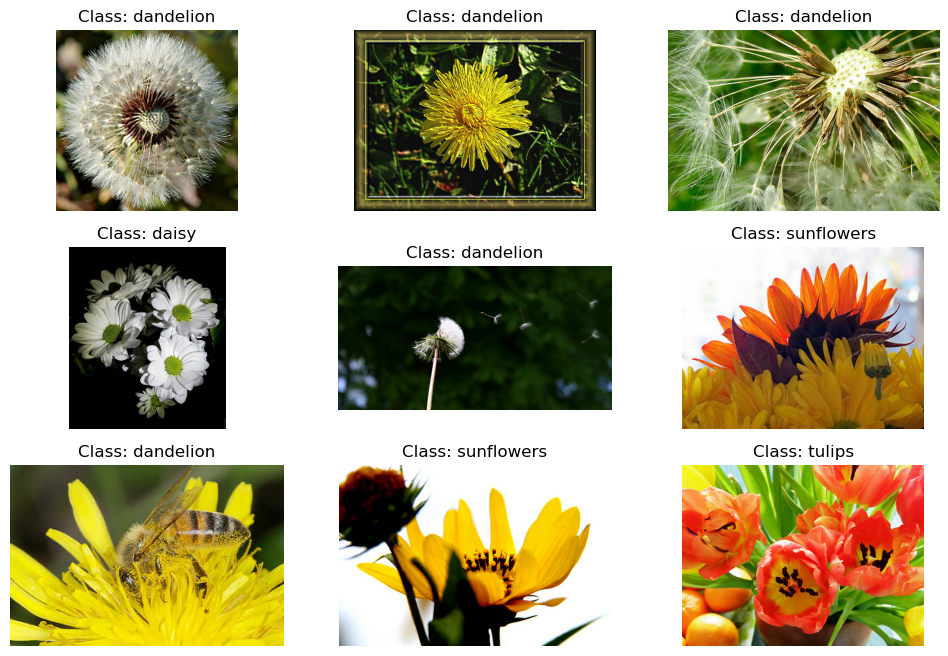

In [7]:
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title('Class: {}'.format(class_names[label]))
    plt.axis('off')

plt.show(block=False)

In [8]:
def preprocess(_image, _label):
    resized_image = tf.image.resize(_image, [224, 224])
    return resized_image, _label

In [9]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_row.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


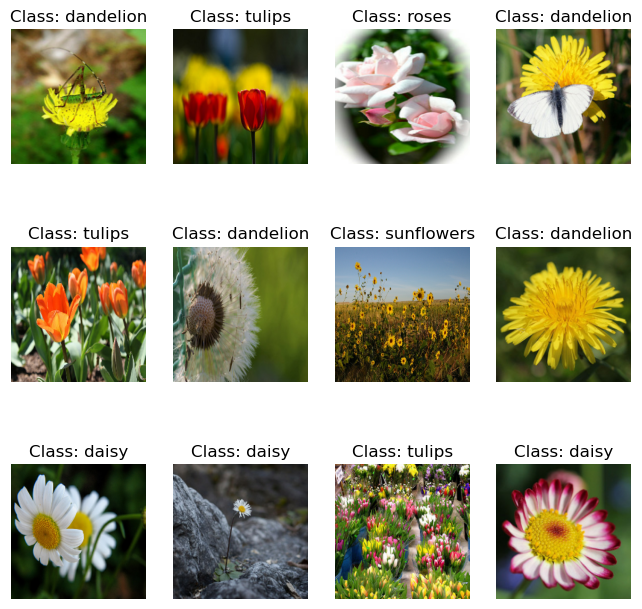

In [12]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)

for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title('Class: {}'.format(class_names[y_batch[index]]))
        plt.axis('off')

plt.show()

## Exercise 2.2.2

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0)

train_set_scaled = train_set.map(lambda x, y: (rescale(x), y))
valid_set_scaled = valid_set.map(lambda x, y: (rescale(x), y))
test_set_scaled = test_set.map(lambda x, y: (rescale(x), y))

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set_scaled, epochs=10, validation_data=valid_set_scaled)

In [12]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

result = (acc_train, acc_valid, acc_test)
print(result)

12/12 [==============================] - 2s 175ms/step - loss: 698.9130 - accuracy: 0.4823
(0.9011628031730652, 0.45190563797950745, 0.48228883743286133)


In [3]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
with open('simple_cnn_acc.pkl', 'wb') as filename:
    pickle.dump(result, filename)

## Exercise 2.3

In [13]:
def preprocess(_image, _label):
    resized_image = tf.image.resize(_image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, _label

In [14]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_row.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


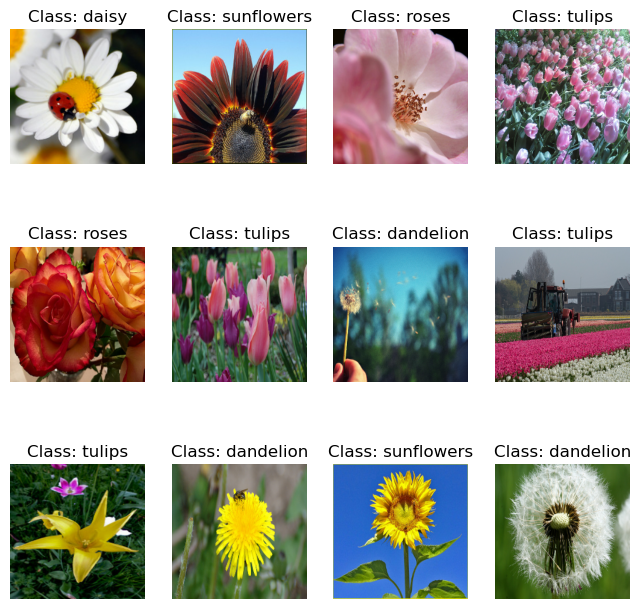

In [15]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title('Class: {}'.format(class_names[y_batch[index]]))
        plt.axis('off')

plt.show()

In [16]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)

In [17]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_set, epochs=5, validation_data=valid_set)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 169s 2s/step - loss: 0.7085 - accuracy: 0.7609 - val_loss: 0.5099 - val_accuracy: 0.8348
Epoch 2/5
86/86 [==============================] - 167s 2s/step - loss: 0.3875 - accuracy: 0.8692 - val_loss: 0.4563 - val_accuracy: 0.8258
Epoch 3/5
86/86 [==============================] - 163s 2s/step - loss: 0.3145 - accuracy: 0.8946 - val_loss: 0.4024 - val_accuracy: 0.8730
Epoch 4/5
86/86 [==============================] - 163s 2s/step - loss: 0.2700 - accuracy: 0.9161 - val_loss: 0.3880 - val_accuracy: 0.8748
Epoch 5/5
86/86 [==============================] - 158s 2s/step - loss: 0.2367 - accuracy: 0.9299 - val_loss: 0.3847 - val_accuracy: 0.8584
Epoch 1/5


In [ ]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

result = (acc_train, acc_valid, acc_test)
print(result)

In [ ]:
with open('xception_acc.pkl', 'wb') as filename:
    pickle.dump(result, filename)